# Step_6_Visualizing_Sentiment Analysis
### Roy Madpis (319091526) And Michael Kobaivanov (206814485)

In this notebook we use all the data we collected so far to collect insights regarding the Brexit issue.
    
### 1. Sentiment Analysis
We would like to use the predicted sentiment to drive some insights.


In [1]:
#! pip3 freeze > roy_libs1.txt

In [2]:
#! pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user gensim
#! pip install dask
#! pip install tabulate
#! pip install nltk
#! pip install langid # for language detection
# ! pip install contractions #for cleaning the text - converting abbriviations to long text for example

### downloading the 4.5M tweets with sentiment
#! curl --remote-name-all https://www.clarin.si/repository/xmlui/bitstream/handle/11356/1135{/Brexit_tweets_stance.zip}


ERROR: Invalid requirement: '#'


In [21]:
import pandas as pd, numpy as np, os
import seaborn as sns

import os.path
import matplotlib.pyplot as plt
import string
import psutil
import sys, requests
import time, datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from dask import dataframe as dd
import collections
from collections import Counter
from tqdm.notebook import tqdm_notebook

#for readin zip files
import zipfile
import bz2
import itertools
import codecs
import io

import pickle
from scipy import spatial
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import inspect
import contractions
import langid #for language detection
#import logging
#logging.basicConfig(format ='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR)

#stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


#####################################
data_folder = "data_folder"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roymad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
### reading the stopwords file / downloading it and add some more stopwords

stopwords_file_name =  os.path.join(data_folder, "StopWords")
stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"


stop_words_to_add = ["http", "https", "rt", "co", "vrkhaxde", "oeblog", "rln", "simonjhix", "cctvqfr",
"dcpj", "xvy", "mycekvwlxr", "imydbvvwji", "kkd", "rwp","yfc","fus","tmawgoafhb","edzmidvpel", "brexit.", "brexit,",
"xmljwysih", "lnfgc", "https//t.co/gx1lpjz5ux", "gvabanwvhi", "fmgynqxrs", "https//t.co/zpwcyltwgk", "https//t.co/eacccme91i",
"https//t.co/memxwp57du", "https//t.co/kgjzyab6vu", "vxpgogryp", "https//t.co/l7cfc70l1w"] ### add more stopwords you want
#################################################################
if not os.path.isfile(stopwords_file_name):
    StopWords = requests.get(stopwords_url).text.split()
    with open(stopwords_file_name,'w+t', encoding='utf-8') as out_file:
        out_file.write(' '.join(StopWords))
else:
    with open(stopwords_file_name,'rt', encoding='utf-8') as in_file:
        StopWords = in_file.readline().split()
StopWords = set(StopWords)

for word_i in stop_words_to_add:
    StopWords.add(word_i)

## 5.1.a Reading Key Opinion leaders tweets:


a. We split the ~1M tweets data (data_folder/tweets_table_all_with_sentimet.csv) by the year the tweet was published, train a Word2Vec model for each year alone (thus have word2vec model that was trained on tweets from 2014 / model that was trained on tweets from 2015, etc) we also have one Word2Vec model that was trained on all the data.

In [3]:
dir_with_all_tweets = os.path.join(data_folder,"Predicted_sentiment_tables")

print("Step 1: Reading all the csv files")
tweets_tables = []
csv_files_evaluated = []
for root,dirs,files in os.walk(dir_with_all_tweets):
    for file in files:
        if file.endswith(".csv"): #if the file is csv
            csv_files_evaluated.append(file)
            file_location = os.path.join(dir_with_all_tweets, file)
            tweets_tables.append(pd.read_csv(file_location))

tweets_table_all_with_sentimet_0 = pd.concat(tweets_tables)
print("There are:", tweets_table_all_with_sentimet_0.shape[0], "Tweets")

tweets_table_all_with_sentimet_0 = tweets_table_all_with_sentimet_0.drop(labels = ["Unnamed: 0", "index_num"], axis = 1)
tweets_table_all_with_sentimet_0.head()

Step 1: Reading all the csv files
There are: 979801 Tweets


,author_id,author_id_new,conv_id_new,conversation_id,created_at,entities.mentions,id,id_new,public_metrics.like_count,public_metrics.quote_count,...,users.public_metrics.followers_count,users.public_metrics.following_count,users.public_metrics.listed_count,users.public_metrics.tweet_count,users.username,users.verified,text_tokens,created_at_date,Year_tweet,Predicted_sentiment
0,76650839,author_id: 76650839,conv_id: 1079747729419657217,1079747729419657217,2018-12-31T14:34:54.000Z,"[{'start': 3, 'end': 19, 'username': '10Downin...",1079747729419657217,id: 1079747729419657217,0,0,...,14060,2210,654,10740,AlunCairns,True,"['downingstreet', 'countries', 'places', 'uk',...",2018-12-31,2018,Neutral
1,76650839,author_id: 76650839,conv_id: 1079747690110570496,1079747690110570496,2018-12-31T14:34:44.000Z,"[{'start': 3, 'end': 19, 'username': 'GavinWil...",1079747690110570496,id: 1079747690110570496,0,0,...,14060,2210,654,10740,AlunCairns,True,"['gavinwilliamson', 'want_thank', 'serving', '...",2018-12-31,2018,Positive
2,76650839,author_id: 76650839,conv_id: 1078943309744070657,1078943309744070657,2018-12-29T09:18:25.000Z,"[{'start': 3, 'end': 14, 'username': 'UKGovWal...",1078943309744070657,id: 1078943309744070657,0,0,...,14060,2210,654,10740,AlunCairns,True,"['ukgovwales_welsh_secretary_aluncairns', 'ext...",2018-12-29,2018,Positive
3,76650839,author_id: 76650839,conv_id: 1078738567193640960,1078738567193640960,2018-12-28T19:58:04.000Z,"[{'start': 0, 'end': 13, 'username': 'TicketTa...",1078741894761463809,id: 1078741894761463809,1,0,...,14060,2210,654,10740,AlunCairns,True,"['tickettattle', 'tfwrail', 'sure', 'thing']",2018-12-28,2018,Neutral
4,76650839,author_id: 76650839,conv_id: 1077967555879452672,1077967555879452672,2018-12-26T21:24:01.000Z,"[{'start': 0, 'end': 13, 'username': 'WPL_Offi...",1078038748837888001,id: 1078038748837888001,3,0,...,14060,2210,654,10740,AlunCairns,True,"['wpl_official', 'barrytownunited', 'the_nomad...",2018-12-26,2018,Positive


### Reading the table with 300k tweets with sentiments
This is the data that we read from twitter using th tweet-ids) [this data is out of the corpus of 4.5M tweet-ids with sentiment]

We need to preprocess that table so it would be in the same format and shape as the table we have above

In [4]:
data_folder_name_for_sentiment = "data_folder/tweets_4_5M/tweet_ids_with_sentiment"

print("Step 1: Reading all the csv files")
tweets_tables = []
csv_files_evaluated = []
for root,dirs,files in os.walk(data_folder_name_for_sentiment):
    for file in files:
        if file.endswith(".csv"): #if the file is csv
            csv_files_evaluated.append(file)
            file_location = os.path.join(data_folder_name_for_sentiment, file)
            tweets_tables.append(pd.read_csv(file_location))

tweets_with_sentiment_300k = pd.concat(tweets_tables)
print("There are:", tweets_with_sentiment_300k.shape[0], "Tweets")

### preprocess

## change the sentiment column name
tweets_with_sentiment_300k = tweets_with_sentiment_300k.rename({"sentimnt":"Predicted_sentiment"}, axis = 1)

tweets_with_sentiment_300k["text_tokens"] = 0

def take_only_10_first_char(x):
    return(x[0:10])
tweets_with_sentiment_300k["created_at_date"] = tweets_with_sentiment_300k["created_at"].apply(take_only_10_first_char)
tweets_with_sentiment_300k["created_at_date"] = pd.to_datetime(tweets_with_sentiment_300k["created_at_date"])

tweets_with_sentiment_300k["Year_tweet"] = pd.DatetimeIndex(tweets_with_sentiment_300k['created_at']).year
tweets_with_sentiment_300k = tweets_with_sentiment_300k.drop(labels = ["Unnamed: 0","tweet_id"], axis = 1)

tweets_with_sentiment_300k.head()

Step 1: Reading all the csv files
There are: 312735 Tweets


,author_id,author_id_new,conv_id_new,conversation_id,created_at,entities.mentions,id,id_new,public_metrics.like_count,public_metrics.quote_count,...,users.public_metrics.followers_count,users.public_metrics.following_count,users.public_metrics.listed_count,users.public_metrics.tweet_count,users.username,users.verified,Predicted_sentiment,text_tokens,created_at_date,Year_tweet
0,137099503,author_id: 137099503,conv_id: 730759365142167552,730759365142167552,2016-05-12T13:59:44.000Z,NaN,730759365142167552,id: 730759365142167552,2,0,...,463,71,18,22398,FonyBlair,False,Neutral,0,2016-05-12,2016
1,367718336,author_id: 367718336,conv_id: 730759317884915712,730759317884915712,2016-05-12T13:59:32.000Z,NaN,730759317884915712,id: 730759317884915712,0,0,...,3623,5000,433,301390,janicemorphet,False,Neutral,0,2016-05-12,2016
2,1299769218,author_id: 1299769218,conv_id: 730759295478960129,730759295478960129,2016-05-12T13:59:27.000Z,NaN,730759295478960129,id: 730759295478960129,4,0,...,558874,359,1630,81943,KayBurley,True,Neutral,0,2016-05-12,2016
3,2772884435,author_id: 2772884435,conv_id: 730759278630424577,730759278630424577,2016-05-12T13:59:23.000Z,NaN,730759278630424577,id: 730759278630424577,0,0,...,1206,1415,25,31524,ernieharding59,False,Positive,0,2016-05-12,2016
4,2867356894,author_id: 2867356894,conv_id: 730759264386617344,730759264386617344,2016-05-12T13:59:20.000Z,NaN,730759264386617344,id: 730759264386617344,0,0,...,2922,2474,122,64418,CandiSpillard,False,Negative,0,2016-05-12,2016


In [5]:
print(tweets_table_all_with_sentimet_0.shape)
print(tweets_with_sentiment_300k.shape)

(979801, 28)
(312735, 28)


In [6]:
### combining the two tables into one big table
tweets_table_all_with_sentimet = pd.concat([tweets_table_all_with_sentimet_0, tweets_with_sentiment_300k])
print("Total number of tweets with sentiment =", tweets_table_all_with_sentimet.shape[0])

### remove duplicates
tweets_table_all_with_sentimet = tweets_table_all_with_sentimet.drop_duplicates(subset=['author_id_new', 'conv_id_new', "id_new", "created_at", "public_metrics.like_count", "text"])
print("Total number of tweets with sentiment not duplicate =", tweets_table_all_with_sentimet.shape[0])

tweets_table_all_with_sentimet.head()

Total number of tweets with sentiment = 1292536
Total number of tweets with sentiment not duplicate = 1285805


,author_id,author_id_new,conv_id_new,conversation_id,created_at,entities.mentions,id,id_new,public_metrics.like_count,public_metrics.quote_count,...,users.public_metrics.followers_count,users.public_metrics.following_count,users.public_metrics.listed_count,users.public_metrics.tweet_count,users.username,users.verified,text_tokens,created_at_date,Year_tweet,Predicted_sentiment
0,76650839,author_id: 76650839,conv_id: 1079747729419657217,1079747729419657217,2018-12-31T14:34:54.000Z,"[{'start': 3, 'end': 19, 'username': '10Downin...",1079747729419657217,id: 1079747729419657217,0,0,...,14060,2210,654,10740,AlunCairns,True,"['downingstreet', 'countries', 'places', 'uk',...",2018-12-31,2018,Neutral
1,76650839,author_id: 76650839,conv_id: 1079747690110570496,1079747690110570496,2018-12-31T14:34:44.000Z,"[{'start': 3, 'end': 19, 'username': 'GavinWil...",1079747690110570496,id: 1079747690110570496,0,0,...,14060,2210,654,10740,AlunCairns,True,"['gavinwilliamson', 'want_thank', 'serving', '...",2018-12-31,2018,Positive
2,76650839,author_id: 76650839,conv_id: 1078943309744070657,1078943309744070657,2018-12-29T09:18:25.000Z,"[{'start': 3, 'end': 14, 'username': 'UKGovWal...",1078943309744070657,id: 1078943309744070657,0,0,...,14060,2210,654,10740,AlunCairns,True,"['ukgovwales_welsh_secretary_aluncairns', 'ext...",2018-12-29,2018,Positive
3,76650839,author_id: 76650839,conv_id: 1078738567193640960,1078738567193640960,2018-12-28T19:58:04.000Z,"[{'start': 0, 'end': 13, 'username': 'TicketTa...",1078741894761463809,id: 1078741894761463809,1,0,...,14060,2210,654,10740,AlunCairns,True,"['tickettattle', 'tfwrail', 'sure', 'thing']",2018-12-28,2018,Neutral
4,76650839,author_id: 76650839,conv_id: 1077967555879452672,1077967555879452672,2018-12-26T21:24:01.000Z,"[{'start': 0, 'end': 13, 'username': 'WPL_Offi...",1078038748837888001,id: 1078038748837888001,3,0,...,14060,2210,654,10740,AlunCairns,True,"['wpl_official', 'barrytownunited', 'the_nomad...",2018-12-26,2018,Positive


In [158]:
# num_of_rows = tweets_table_all_with_sentimet.shape[0]
# num_groups = 100
# print("Number or rows in each group:", round(num_of_rows/num_groups,1))
# split_groups = np.array_split(range(num_of_rows), num_groups)

Number or rows in each group: 9.8


### Preprocess the filtered tweets
After we read the tweets filtered table, we need to perform several cleaning / preprocessing on those filtered tweets

In [7]:
# def clean_text(x):
#     from gensim.utils import simple_preprocess
#     import contractions
#     x = contractions.fix(x)
#     x = ' '.join(simple_preprocess(x))
#     return x

### Pre-processing columns conv_id_new and author_id_new
tweets_table_all_with_sentimet['conversation_id'] = tweets_table_all_with_sentimet['conv_id_new'].apply(lambda x: x.replace("conv_id: ", ""))
tweets_table_all_with_sentimet['author_id'] = tweets_table_all_with_sentimet['author_id_new'].apply(lambda x: x.replace("author_id: ", ""))
#tweets_table_all_with_sentimet['clean_text'] = tweets_table_all_with_sentimet['text'].apply(clean_text)
tweets_table_all_with_sentimet = tweets_table_all_with_sentimet[tweets_table_all_with_sentimet['text'].notna()] #remove rows with nan values in the text column

tweets_table_all_with_sentimet['clean_text'] = tweets_table_all_with_sentimet['text']

if "Year_tweet" in tweets_table_all_with_sentimet.columns:
    years_tweets = tweets_table_all_with_sentimet.Year_tweet
else:
    years_tweets = pd.DatetimeIndex(tweets_table_all_with_sentimet['created_at_date']).year
    tweets_table_all_with_sentimet["Year_tweet"] = years_tweets
### detecting the language of the text + preprocess it
language_classifications = []
tokens_roy = []
years_tweets = []
for row in tqdm_notebook(tweets_table_all_with_sentimet.clean_text): #tqdm_notebook - to pring progress bar
    #language_classification, score = langid.classify(row)
    #language_classifications.append(language_classification)

    data_clean = row.lower().replace("#", "").replace("@", "").replace("?", "").replace("\"", "").replace("\'", "").replace(":", "")
    data_clean = data_clean.split()
    data_clean = [token for token in data_clean if token not in StopWords]
    data_clean = [token for token in data_clean if len(token) >=2]
    tokens_roy.append(data_clean) #

texts = tweets_table_all_with_sentimet.text
text_tokens = tweets_table_all_with_sentimet.text_tokens

  0%|          | 0/1285805 [00:00<?, ?it/s]

In [ ]:
print(len(language_classifications))
print(len(tokens_roy))

In [13]:
import warnings
warnings.filterwarnings('ignore')

#import warnings
#warnings.filterwarnings('default')


## EDA

# word cloud


In [8]:
#wordcloud install from anaconda prompt:
#conda install -c conda-forge wordcloud 

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os


#tweets_texts = list(map(lambda x: x.lower(), tweets_table_all_with_sentimet.text_tokens)) #lower_case
tweets_texts = list(map(lambda x: x, tweets_table_all_with_sentimet.text_tokens)) #lower_case

#remove punctuation and save in one big string (so we can split all the corpus into words)
tweets_texts = str(tweets_texts).translate(str.maketrans('', '', string.punctuation))


Wordcloud - tweets 2014-2021


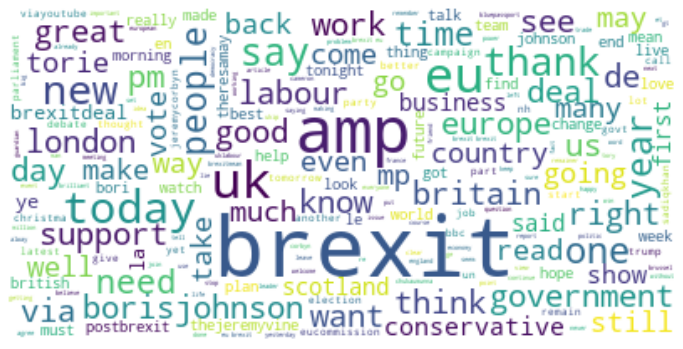

In [19]:
print("Wordcloud - tweets 2014-2021")
wordcloud_final = WordCloud(max_font_size=50, background_color="white")
wordcloud_final = wordcloud_final.generate(tweets_texts)

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud_final, interpolation="bilinear")
plt.axis("off")
plt.show();
fig.savefig('486.full.png', transparent=True, format='png')

## More EDA on the tweeets metrices:

In [32]:
### summary table for all the tweets
summary_sentiment_likes = tweets_table_all_with_sentimet.groupby(['Predicted_sentiment','Year_tweet'])[['public_metrics.like_count',
                                                                                                        "public_metrics.quote_count",
                                                                                                       "public_metrics.reply_count",
                                                                                                       "public_metrics.retweet_count"]].mean()

In [61]:
## summary table for a specific KOL
KOL_Name = "Jeremy Corbyn"
specific_KOL = tweets_table_all_with_sentimet[tweets_table_all_with_sentimet["users.name"] == KOL_Name]

specific_KOL["Predicted_sentiment_backup"] = specific_KOL["Predicted_sentiment"]
specific_KOL["Predicted_sentiment"] = KOL_Name + " " + specific_KOL["Predicted_sentiment"]

#df['col'] = 'str' + df['col'].astype(str)

summary_sentiment_likes_KOL = specific_KOL.groupby(['Predicted_sentiment','Year_tweet'])[['public_metrics.like_count',
                                                                                                        "public_metrics.quote_count",
                                                                                                       "public_metrics.reply_count",
                                                                                                       "public_metrics.retweet_count"]].mean()

C:\Users\Roy\AppData\Local\Temp/ipykernel_20004/3595346794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_KOL["Predicted_sentiment_backup"] = specific_KOL["Predicted_sentiment"]
C:\Users\Roy\AppData\Local\Temp/ipykernel_20004/3595346794.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_KOL["Predicted_sentiment"] = KOL_Name + " " + specific_KOL["Predicted_sentiment"]


In [62]:
summary_sentiment_likes_KOL.head()

public_metrics.like_count  \
Predicted_sentiment    Year_tweet                              
Jeremy Corbyn Negative 2014                        80.641509   
                       2015                       750.756757   
                       2016                       948.815851   
                       2017                      3225.188020   
                       2018                      3058.935115   

                                   public_metrics.quote_count  \
Predicted_sentiment    Year_tweet                               
Jeremy Corbyn Negative 2014                         18.490566   
                       2015                          0.405405   
                       2016                         25.484848   
                       2017                         89.790349   
                       2018                        113.572519   

                                   public_metrics.reply_count  \
Predicted_sentiment    Year_tweet                               
Jeremy Corbyn Negative 2014                          7.660377   
                       2015                         79.720721   
                       2016                         72.034965   
                       2017                        194.703827   
                       2018                        294.311069   

                                   public_metrics.retweet_count  
Predicted_sentiment    Year_tweet                                
Jeremy Corbyn Negative 2014                          113.415094  
                       2015                          826.810811  
                       2016                          844.841492  
                       2017                         1736.675541  
                       2018                         1700.711832

In [63]:
#combining the summary table of all the tweet with the one of the specific KOL
summary_sentiment_all = pd.concat([summary_sentiment_likes_KOL, summary_sentiment_likes])

In [64]:
summary_sentiment_all.head()

public_metrics.like_count  \
Predicted_sentiment    Year_tweet                              
Jeremy Corbyn Negative 2014                        80.641509   
                       2015                       750.756757   
                       2016                       948.815851   
                       2017                      3225.188020   
                       2018                      3058.935115   
                       2019                      6536.403537   
                       2020                     20035.590909   
Jeremy Corbyn Neutral  2014                         8.826772   
                       2015                       411.074074   
                       2016                       543.377633   
                       2017                      2711.413431   
                       2018                      1805.659292   
                       2019                      7222.384532   
                       2020                     21248.875000   
Jeremy Corbyn Positive 2014                        15.857923   
                       2015                       432.164103   
                       2016                       717.871826   
                       2017                      2825.594848   
                       2018                      3084.318715   
                       2019                      7603.971906   
                       2020                      7516.892857   
Negative               2014                        13.625826   
                       2015                        11.569870   
                       2016                        12.026387   
                       2017                       199.029552   
                       2018                       218.421090   
                       2019                       450.263066   
                       2020                        68.209142   
                       2021                        42.173259   
Neutral                2014                        20.776429   
                       2015                        32.257137   
                       2016                        26.954372   
                       2017                       204.238859   
                       2018                       210.402638   
                       2019                       366.071107   
                       2020                        55.818422   
                       2021                        23.664472   
Positive               2014                        18.625585   
                       2015                        26.370191   
                       2016                        29.327958   
                       2017                       260.545641   
                       2018                       287.967737   
                       2019                       763.096323   
                       2020                       128.911609   
                       2021                        60.980366   

                                   public_metrics.quote_count  \
Predicted_sentiment    Year_tweet                               
Jeremy Corbyn Negative 2014                         18.490566   
                       2015                          0.405405   
                       2016                         25.484848   
                       2017                         89.790349   
                       2018                        113.572519   
                       2019                        196.041801   
                       2020                        661.454545   
Jeremy Corbyn Neutral  2014                          0.251969   
                       2015                          0.298611   
                       2016                         23.188090   
                       2017                        107.279119   
                       2018                         76.269912   
                       2019                        264.423747   
                       2020                       1

limit_output extension: Maximum message size of 10000 exceeded with 12222 characters

## Mean likes Per year

In [67]:
KOL_Neutral = KOL_Name + " " + "Neutral"
KOL_Positive = KOL_Name + " " + "Positive"
KOL_Negative = KOL_Name + " " + "Negative"


Text(0.5, 1.0, 'Line plot of mean likes pear year')

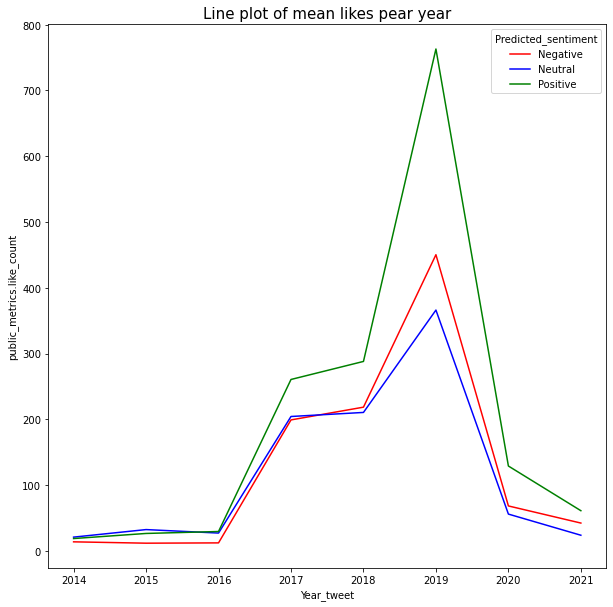

In [69]:
data_table =  summary_sentiment_likes #summary_sentiment_all
what_we_see_in_the_graph = "likes"
fig, ax = plt.subplots(figsize=(10,10))

palette ={"Neutral": "blue",
          "Positive": "Green",
          "Negative": "red"}

title_line_plot = "Line plot of mean " + str(what_we_see_in_the_graph) + " pear year"


sns.lineplot(x = "Year_tweet", y = "public_metrics.like_count", data = data_table,
            hue = "Predicted_sentiment", ax = ax, palette = palette).set_title(title_line_plot, fontsize=15)

Text(0.5, 1.0, 'Line plot of mean likes pear year')

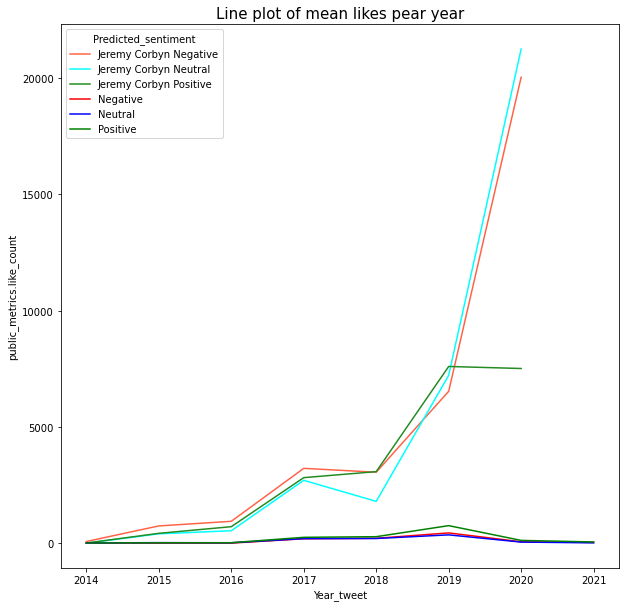

In [68]:
data_table = summary_sentiment_all #summary_sentiment_likes
what_we_see_in_the_graph = "likes"
fig, ax = plt.subplots(figsize=(10,10))

# palette ={"Neutral": "blue",
#           "Positive": "Green",
#           "Negative": "red"}

palette ={"Neutral": "blue",
          "Positive": "Green",
          "Negative": "red",
         KOL_Neutral:"cyan",
         KOL_Positive: "forestgreen",
         KOL_Negative:"tomato"}

title_line_plot = "Line plot of mean " + str(what_we_see_in_the_graph) + " pear year"


sns.lineplot(x = "Year_tweet", y = "public_metrics.like_count", data = data_table,
            hue = "Predicted_sentiment", ax = ax, palette = palette).set_title(title_line_plot, fontsize=15)

## Mean Comments Per year

Text(0.5, 1.0, 'Line plot of mean comments pear year')

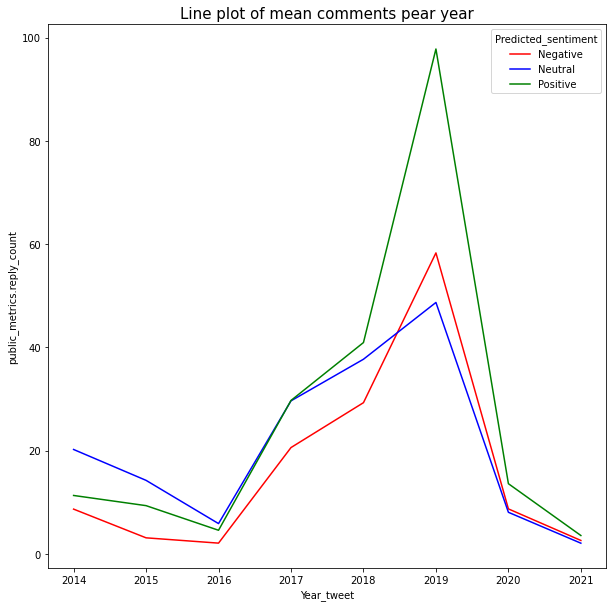

In [34]:
what_we_see_in_the_graph = "comments"
fig, ax = plt.subplots(figsize=(10,10))


palette ={"Neutral": "blue",
          "Positive": "Green",
          "Negative": "red"}

title_line_plot = "Line plot of mean " + str(what_we_see_in_the_graph) + " pear year"


sns.lineplot(x = "Year_tweet", y = "public_metrics.reply_count", data = summary_sentiment_likes,
            hue = "Predicted_sentiment", ax = ax, palette = palette).set_title(title_line_plot, fontsize=15)

## Mean Quotes Per year

Text(0.5, 1.0, 'Line plot of mean quotes pear year')

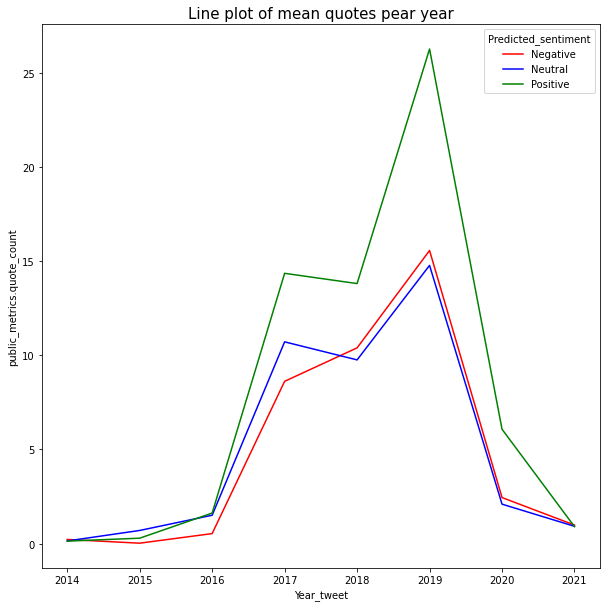

In [35]:
what_we_see_in_the_graph = "quotes"
fig, ax = plt.subplots(figsize=(10,10))


palette ={"Neutral": "blue",
          "Positive": "Green",
          "Negative": "red"}

title_line_plot = "Line plot of mean " + str(what_we_see_in_the_graph) + " pear year"


sns.lineplot(x = "Year_tweet", y = "public_metrics.quote_count", data = summary_sentiment_likes,
            hue = "Predicted_sentiment", ax = ax, palette = palette).set_title(title_line_plot, fontsize=15)

## Mean Retweets Per year

Text(0.5, 1.0, 'Line plot of mean quotes pear year')

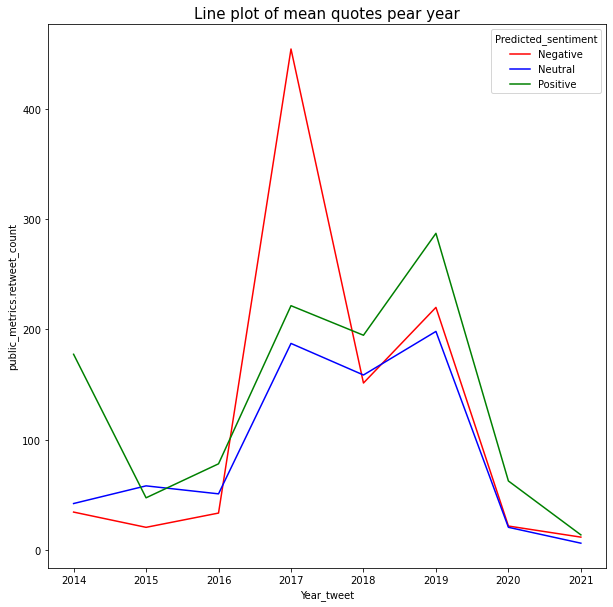

In [36]:
what_we_see_in_the_graph = "Retweets"
fig, ax = plt.subplots(figsize=(10,10))


palette ={"Neutral": "blue",
          "Positive": "Green",
          "Negative": "red"}

title_line_plot = "Line plot of mean " + str(what_we_see_in_the_graph) + " pear year"


sns.lineplot(x = "Year_tweet", y = "public_metrics.retweet_count", data = summary_sentiment_likes,
            hue = "Predicted_sentiment", ax = ax, palette = palette).set_title(title_line_plot, fontsize=15)

<AxesSubplot:xlabel='Year_tweet', ylabel='public_metrics.like_count'>

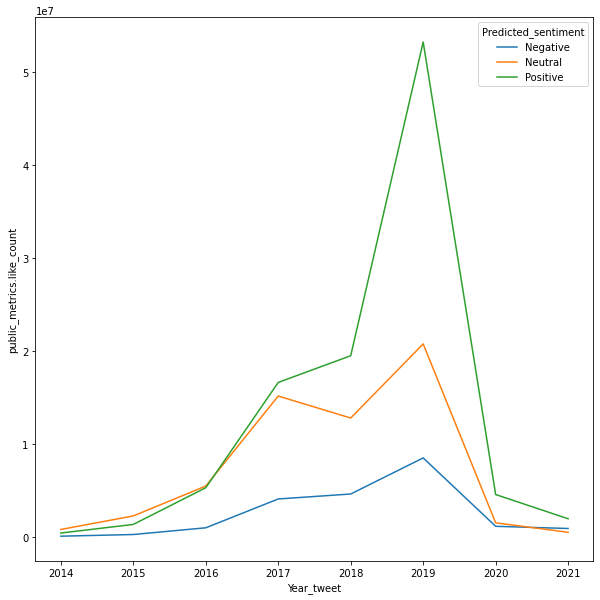

In [27]:
fig, ax = plt.subplots(figsize=(10,10))


sns.lineplot(x = "Year_tweet", y = "public_metrics.like_count", data = summary_sentiment_likes,
            hue = "Predicted_sentiment", ax = ax)

KeyboardInterrupt: 

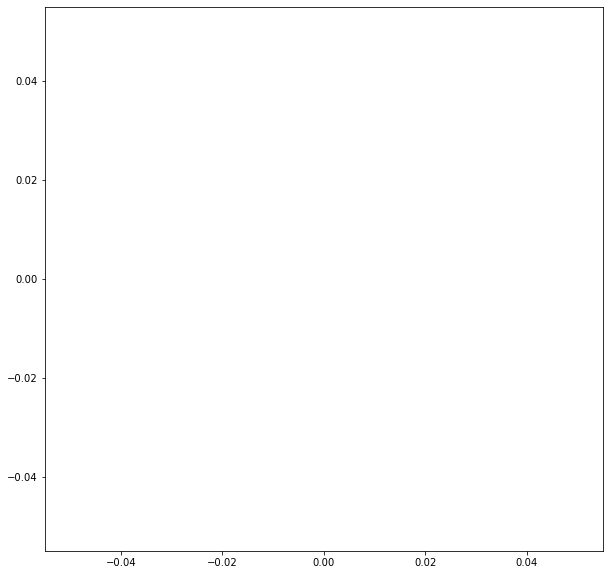

In [21]:
fig, ax = plt.subplots(figsize=(10,10))


sns.lineplot(x = "Year_tweet", y = "public_metrics.like_count", data = tweets_table_all_with_sentimet,
            hue = "Predicted_sentiment", ax = ax)

In [ ]:
palette ={"Neutral": "blue",
          "Positive": "Green",
          "Negative": "red"}



sns.lineplot(x = "Year_tweet", y = "public_metrics.like_count", data = tweets_table_all_with_sentimet,
            hue = "Predicted_sentiment", ax = ax, palette = palette)

## Sentiment analysis

Here we present the EDA we conducted using the sentiment prediction (that was the outcome of the sentiment model)